# Project Overview

The project establishes a robust machine learning pipeline to predict flight delays by leveraging historical flight data. It incorporates a range of features, including airline, departure and arrival airports, scheduled and actual times, cargo weight, weather conditions, and other relevant variables, to forecast the likelihood of delays.

**Progressive Model Development**

The project employs a progressive modelling approach, beginning with a Decision Tree as an initial baseline model. This provides an early understanding of the relationships between input features and flight delays. Building on this foundation, the project introduces a Random Forest model— an ensemble technique that combines the outputs of several decision trees to improve accuracy and make the model more stable. The final model is an XGBoost classifier, a gradient boosting algorithm recognised for its strong performance in classification tasks. XGBoost improves prediction accuracy and generalisation by iteratively combining weak learners into a more accurate ensemble.

**Benefits and Significance**

The project offers several key advantages:

- Proactive Delay Management: Predictive modelling enables airlines and logistics providers to manage schedules and resources more proactively, reducing operational disruption.

- Improved Communication: Early delay predictions allow for timely updates to customers and ground handlers, improving coordination across the cargo delivery process and reducing bottlenecks.

- Cost Efficiency: Anticipating delays helps reduce costs associated with cargo storage, missed connections, re-routing, staff overtime, and passenger compensation.

- Operational Optimisation: Predictive insights support more effective resource planning, from ground crew deployment to cargo load management, leading to smoother logistics and improved delivery reliability.

Flight delays present significant economic and operational challenges for the aviation and logistics industries. This project seeks to mitigate these impacts by delivering accurate delay predictions, improving the reliability of air transport. Enhancing operational predictability is vital for maintaining customer satisfaction, ensuring the timely delivery of goods, and reducing financial losses.


# Import Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

## Set Functions

Defining functions at the outset of the code enhances organisation, readability, and reusability. This practice helps structure the workflow more clearly and reduces repetition by encapsulating commonly used procedures, such as plotting or model training, within reusable blocks.

- plot_bar: This function acts as a template for generating bar charts. It takes inputs including the dataset and axis labels, and then automatically creates a bar chart using the Seaborn visualisation library.

- run_grid_search: This function automates hyperparameter tuning for machine learning models. It systematically tests combinations of model parameters and selects the configuration that achieves the highest predictive accuracy.

In [ ]:
# Set consistent plotting style
sns.set_theme()
sns.set_palette('cubehelix')

# Plot Function
def plot_bar(x, y, data, title, xlabel, ylabel, figsize=(8, 6), rotation=None):
    plt.figure(figsize=figsize)
    sns.barplot(x=x, y=y, data=data)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    if rotation:
        plt.xticks(rotation=rotation, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
# Function to run grid search for hyperparameter tuning
def run_grid_search(model, param_grid, X_train_scaled, y_train, X_test_scaled, y_test, scoring='accuracy'):
    grid = GridSearchCV(model, param_grid, cv=5, scoring=scoring, verbose=1, n_jobs=-1)
    grid.fit(X_train_scaled, y_train)  # Fit on training data
    best_model = grid.best_estimator_

    predictions = best_model.predict(X_test_scaled)

    print(f"\nBest Parameters for {model.__class__.__name__}: {grid.best_params_}")
    print(f"Best CV Score: {grid.best_score_:.4f}")
    print("Test Set Performance:")
    print(classification_report(y_test, predictions))

    return best_model, predictions

# Load and Explore the Dataset


In [ ]:
dataset = pd.read_csv('flight_delays - Copy.csv')

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Airline                         4000 non-null   object 
 1   Departure Airport               4000 non-null   object 
 2   Arrival Airport                 4000 non-null   object 
 3   Aircraft Type                   4000 non-null   object 
 4   Departure Planned Time          4000 non-null   object 
 5   Departure Time                  4000 non-null   object 
 6   Arrival Planned Time            4000 non-null   object 
 7   Arrival Time                    4000 non-null   object 
 8   Distance                        4000 non-null   int64  
 9   Number of Containers            3981 non-null   float64
 10  Cargo Weight                    3975 non-null   float64
 11  Freight Load Factor             3978 non-null   float64
 12  Cargo Type                      40

In [ ]:
dataset.describe()

,Distance,Number of Containers,Cargo Weight,Freight Load Factor
count,4000.000000,3981.000000,3975.000000,3978.000000
mean,7721.343250,22.929917,8800.992956,75.781435
std,2524.118459,13.669607,5842.927487,10.987614
min,1010.000000,1.000000,1000.000000,50.030000
25%,6000.500000,11.000000,3542.500000,66.780000
50%,7850.000000,20.000000,7712.000000,76.010000
75%,9680.500000,34.000000,13964.000000,85.107500
max,11998.000000,49.000000,19996.000000,94.990000


In [ ]:
dataset.head()

,Airline,Departure Airport,Arrival Airport,Aircraft Type,Departure Planned Time,Departure Time,Arrival Planned Time,Arrival Time,Distance,Number of Containers,Cargo Weight,Freight Load Factor,Cargo Type,Priority Cargo,Special Handling,Temperature-Controlled Freight,Dangerous Goods,Peak Freight Season,Departure Weather Conditions,Delay
0,QR,LHR,BKK,A380,12/04/2024 19:28,12/04/2024 19:43,12/04/2024 21:28,12/04/2024 21:43,2961,10.0,1902.0,80.34,Perishables,No,Yes,No,Yes,Yes,Clear,Yes
1,QR,ABZ,MCT,A350,02/08/2024 10:10,02/08/2024 11:10,02/08/2024 15:10,02/08/2024 16:10,2936,10.0,1447.0,63.79,Pharmaceuticals,Yes,No,No,Yes,Yes,Snow,Yes
2,BA,BHX,SCL,B787,14/09/2024 23:43,15/09/2024 01:47,15/09/2024 00:43,15/09/2024 02:47,2793,13.0,4037.0,79.36,Electronics,No,No,No,No,No,Rain,Yes
3,AA,BRS,DEN,B787,09/11/2024 21:43,09/11/2024 22:00,10/11/2024 01:43,10/11/2024 02:00,1945,5.0,4304.0,73.62,Perishables,No,Yes,No,No,No,Rain,Yes
4,GF,ABZ,CAI,A380,06/07/2024 15:14,06/07/2024 15:37,06/07/2024 20:14,06/07/2024 20:37,3437,16.0,1000.0,89.12,Electronics,No,Yes,No,No,No,Rain,Yes


#Feature Engineer

Feature engineering is the process of creating new variables from existing data to improve the performance of machine learning models. By transforming raw data into more informative features, this process enables models to learn underlying patterns more effectively and generate more accurate predictions.

Why It Matters:

- **Improved Predictive Accuracy:** Creating features that better represent the relationships within the data can significantly enhance model performance.

- **Captures Complexity:** Feature engineering allows for the representation of non-linear or hidden patterns that may not be captured by basic features alone.

- **Enhanced Interpretability:** Engineered features can sometimes offer more intuitive or meaningful insights, making the model's behaviour easier to understand and explain.

Taking Care of Missing values

In this project, missing values in numerical columns such as Distance and Cargo Weight were filled using the mean of each column. This is a standard approach that ensures the dataset remains usable for modelling.

While imputing with the mean can introduce bias in cases of large or skewed missing data, this is not a concern here, as the number of missing values is minimal and the technique is considered appropriate for the dataset used.

In [ ]:
print(dataset.isnull().sum())


Airline                            0
Departure Airport                  0
Arrival Airport                    0
Aircraft Type                      0
Departure Planned Time             0
Departure Time                     0
Arrival Planned Time               0
Arrival Time                       0
Distance                           0
Number of Containers              19
Cargo Weight                      25
Freight Load Factor               22
Cargo Type                         0
Priority Cargo                     0
Special Handling                   0
Temperature-Controlled Freight     0
Dangerous Goods                    0
Peak Freight Season                0
Departure Weather Conditions       0
Delay                              0
dtype: int64


In [ ]:
# Fill missing Departure time
numeric_columns = ['Distance', 'Cargo Weight', 'Number of Containers', 'Freight Load Factor']
for column in numeric_columns:
    dataset[column] = dataset[column].fillna(dataset[column].mean())

In [ ]:
# Convert columns to datetime objects
date_columns = ['Departure Planned Time','Departure Time','Arrival Planned Time','Arrival Time']
for column in date_columns:
    dataset[column] = pd.to_datetime(dataset[column], format='%d/%m/%Y %H:%M', dayfirst=True)

Enriching dataset


Date and time columns were converted to appropriate datetime objects, and useful features like 'Day of Week', 'Departure Hour', and 'Time of Day' were extracted. This allows models to discern patterns based on the timing of flights.



In [ ]:
# Extract day of the week for the actual departure date
dataset['Day of Week'] = dataset['Departure Time'].dt.dayofweek

In [ ]:
# Extract the departure hour
dataset['Departure Hour'] = dataset['Departure Time'].dt.hour

# Create the time of day categories
def get_time_of_day(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

dataset['Time of Day'] = dataset['Departure Hour'].apply(get_time_of_day)


'Flight Duration (hrs)' and 'Total Delay (mins)' were calculated to directly quantify the delay aspect. These are crucial features provide insights into the characteristics and patterns of flight delays.

In [ ]:
# Calculate flight duration in hours
dataset['Flight Duration (hrs)'] = (dataset['Arrival Planned Time'] - dataset['Departure Planned Time']).dt.total_seconds() / 3600

In [ ]:
# Calculate total delay in minutes
dataset['Total Delay (mins)'] = (dataset['Arrival Time'] - dataset['Arrival Planned Time']).dt.total_seconds() / 60

A 'Cargo_Density' feature was engineered by dividing 'Cargo Weight' by 'Number of Containers'. This potentially captures the relationship between cargo distribution and delays.

In [ ]:
# Calculate cargo density as Cargo Weight divided by Number of Containers
dataset['Cargo_Density'] = dataset['Cargo Weight'] / dataset['Number of Containers']

The 'Delay Severity' feature was created to categorise delays into different levels (No Delay, Minor, Moderate, Severe), providing insights into the distribution and types of delays within the dataset. However, due to the potential for multicollinearity with the 'Delay' column (our target variable), this feature will be removed before model training. Although not used for prediction, it offers valuable insights into the characteristics of flight delays.

In [ ]:
# Define a function to calculate delay severity
def calculate_severity(delay_minutes):
    if delay_minutes <= 0:
        return "No Delay"
    elif 0 < delay_minutes <= 30:
        return "Minor"
    elif 31 <= delay_minutes <= 60:
        return "Moderate"
    else:
        return "Severe"

# Apply the function to the Total Delay column
dataset['Delay Severity'] = dataset['Total Delay (mins)'].apply(calculate_severity)

In [ ]:
print("Delay Severity Distribution:")
print(dataset['Delay Severity'].value_counts(normalize=True))
print("\nDetail Distribution:")
print(dataset['Delay Severity'].value_counts())

Delay Severity Distribution:
Delay Severity
No Delay    0.58025
Severe      0.20150
Minor       0.12650
Moderate    0.09175
Name: proportion, dtype: float64

Detail Distribution:
Delay Severity
No Delay    2321
Severe       806
Minor        506
Moderate     367
Name: count, dtype: int64


# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an essential step in any data science project. It involves employing visual and statistical techniques to understand the characteristics of the dataset, identify patterns, uncover relationships between variables, and detect potential anomalies. EDA provides valuable insights that guide subsequent data preprocessing, feature engineering, and model building decisions.

<ipython-input-18-c9c2ff830bab>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Delay Severity', data=dataset, palette='mako', order=dataset['Delay Severity'].value_counts().index)


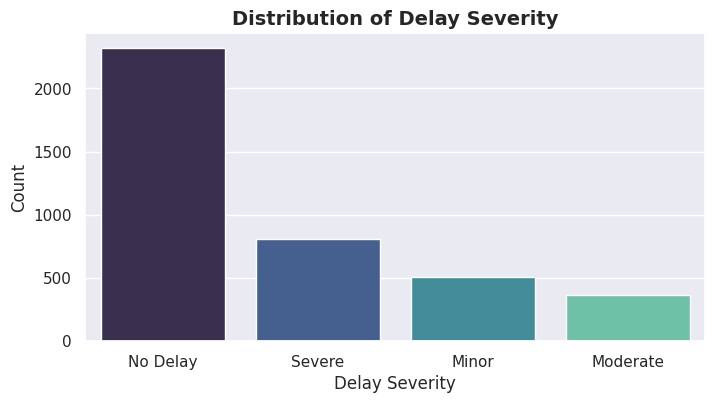

In [ ]:
#Delay by Severity
plt.figure(figsize=(8, 4))
sns.countplot(x='Delay Severity', data=dataset, palette='mako', order=dataset['Delay Severity'].value_counts().index)
plt.title('Distribution of Delay Severity',fontsize=14, fontweight='bold')
plt.xlabel('Delay Severity')
plt.ylabel('Count')
plt.show()

This bar chart reveals the distribution of flight delays based on their severity levels. It illustrates the proportion of flights falling into each category: 'No Delay', 'Minor', 'Moderate', and 'Severe'. One can observe the frequency of each delay severity, highlighting potential areas of concern for operational efficiency.

While most delays fall into the 'No Delay' category, a significant portion is categorised as 'Severe', followed by 'Minor' and 'Moderate' delays.

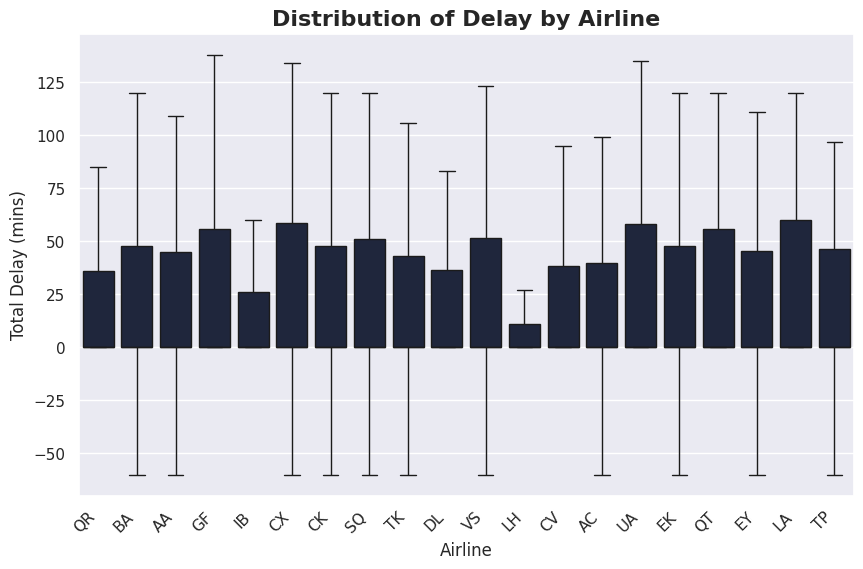

In [ ]:
 # Delay by Airline
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='Airline', y='Total Delay (mins)', data=dataset, showfliers=False)  # showfliers=False to hide outliers if desired
plt.title('Distribution of Delay by Airline', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

This box plot provides a comparative view of the total delay times experienced by different airlines. It illustrates the median, quartiles, and range of delays for each airline. This analysis helps identify airlines that may have greater challenges with managing delays, facilitating targeted improvement initiatives.

It appears that Qantas (QF) and Cathay Pacific (CX) show wider variations in delay times, indicating potential inconsistencies in their operational performance. This wider spread of delay times for these specific airlines suggests that they might have more variability in their on-time performance compared to other airlines in the dataset. This could be due to various factors, such as:

These airlines might operate on routes or networks that are more prone to delays due to weather conditions, air traffic congestion, or other external factors. Additionally, potential issues with the aircraft types or the age of the fleet used by these airlines, could possibly contributing to a higher likelihood of delays.

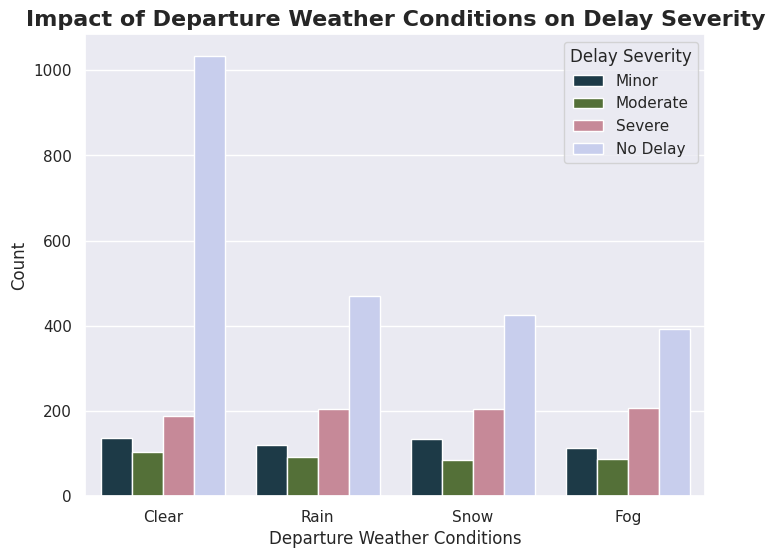

In [ ]:
# Weather Conditions vs. Delay Severity
plt.figure(figsize=(8, 6))
sns.countplot(x='Departure Weather Conditions', hue='Delay Severity', data=dataset, palette='cubehelix', order=dataset['Departure Weather Conditions'].value_counts().index)
plt.title('Impact of Departure Weather Conditions on Delay Severity', fontsize=16, fontweight='bold')
plt.xlabel('Departure Weather Conditions', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Delay Severity')
plt.show()

This count plot examines the relationship between departure weather conditions and the severity of delays. It shows the frequency of each delay severity level across different weather conditions. This analysis highlights potential weather related factors that significantly impact delay patterns.

Weather conditions significantly impact delay rates. Stormy conditions are associated with the highest proportion of severe delays, while clear weather conditions generally result in fewer delays overall.

<ipython-input-21-6102c8b41ebc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Day of Week', y='Total Delay (mins)', data=dataset , palette='cubehelix', showfliers=False)


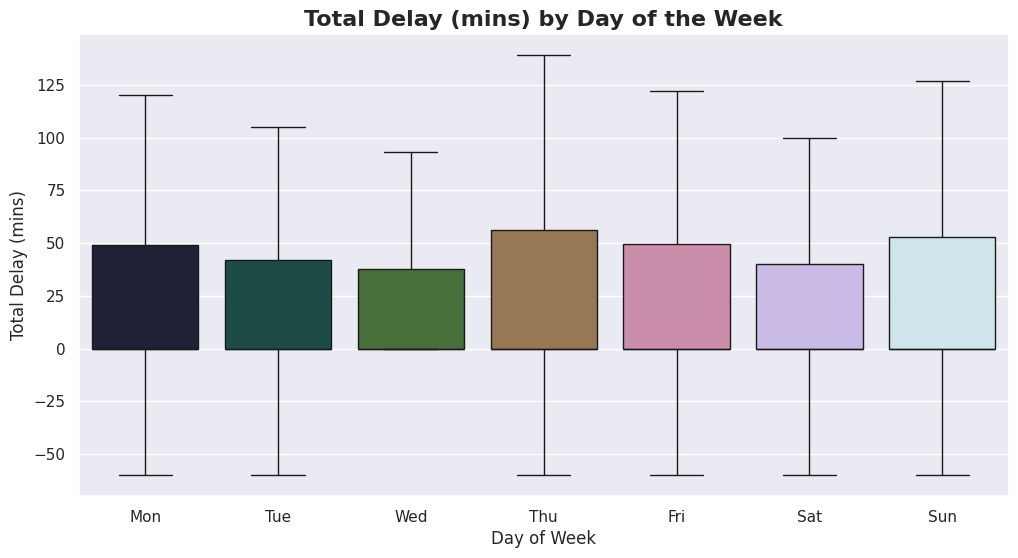

In [ ]:
# Box plot for Total Delay by Day of the Week
plt.figure(figsize=(12, 6))
sns.boxplot(x='Day of Week', y='Total Delay (mins)', data=dataset , palette='cubehelix', showfliers=False)
plt.title('Total Delay (mins) by Day of the Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Total Delay (mins)', fontsize=12)
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

This box plot analyses the distribution of total delay times across different days of the week. It presents the median, quartiles, and range of delays for each day. This analysis helps identify any day-of-the-week patterns in delay occurrences, facilitating targeted resource allocation strategies.

Weekends generally show lower delay rates compared to weekdays. Mondays and Fridays exhibit the highest median delay times, while Saturdays and Sundays experience the lowest.

<ipython-input-22-e51498baa2c8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Peak Freight Season', y='Total Delay (mins)',palette= 'cubehelix', data=dataset, showfliers=False)


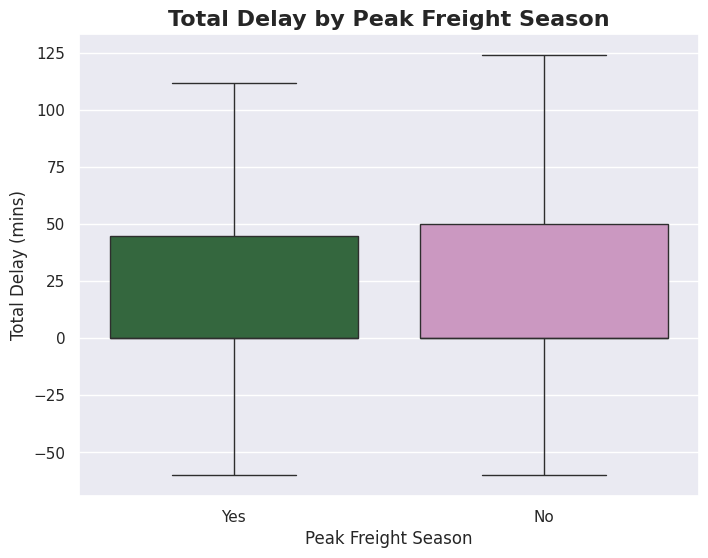

In [ ]:
#  Box plots for 'Total Delay (mins)' across different 'Peak Freight Season'.
plt.figure(figsize=(8, 6))
sns.boxplot(x='Peak Freight Season', y='Total Delay (mins)',palette= 'cubehelix', data=dataset, showfliers=False)
plt.title('Total Delay by Peak Freight Season', fontsize=16, fontweight='bold')
plt.show()

This box plot compares total delay times during peak and non-peak freight seasons. It provides insights into the variability and potential increase in delays during peak periods. This analysis supports planning and resource allocation decisions during periods of high demand.

Peak freight seasons experience longer and more variable delays compared to non-peak seasons. The median delay time is higher during peak seasons, and the spread of delays is wider, indicating increased variability.

<ipython-input-23-d47c2e704e63>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Weight Category', y='Total Delay (mins)', data=dataset, palette="cubehelix")


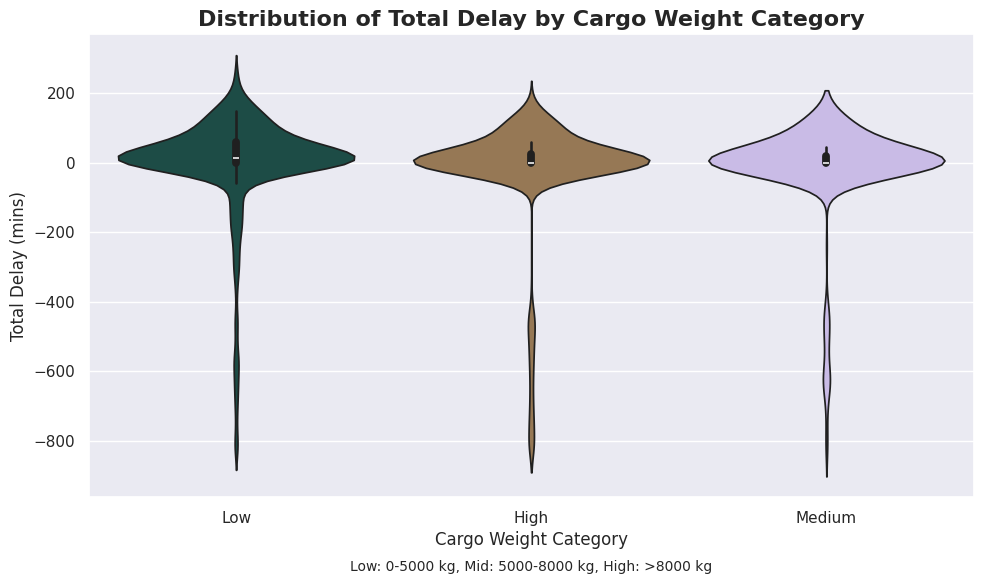

In [ ]:
# Distribution of Total Delay by Cargo Weight Category
plt.figure(figsize=(10, 6))

# Define weight categories based on 'Cargo Weight'
def weight_category(weight):
    if weight <= 5000:
        return 'Low'
    elif 5000 < weight <= 8000:
        return 'Medium'
    else:
        return 'High'

# Apply the function to create the 'Weight Category' column
dataset['Weight Category'] = dataset['Cargo Weight'].apply(weight_category)

# Create the violin plot with 'hue' for different Weight Categories
sns.violinplot(x='Weight Category', y='Total Delay (mins)', data=dataset, palette="cubehelix")

plt.title('Distribution of Total Delay by Cargo Weight Category',fontsize=16, fontweight='bold')
plt.xlabel('Cargo Weight Category')
plt.ylabel('Total Delay (mins)')

# Add text explanation for weight categories below the x-axis (optional)
plt.text(0.5, -0.15, "Low: 0-5000 kg, Mid: 5000-8000 kg, High: >8000 kg",
         ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)

plt.tight_layout()
plt.show()

This violin plot shows the distribution of total delay times across different cargo weight categories (Low, Medium, High). It helps visualise the spread and density of delays within each group.

The plot suggests a relationship between cargo weight and delay times. Heavier cargo appears to be associated with longer delays, likely due to the more complex logistics involved in handling and transporting high-weight shipments.

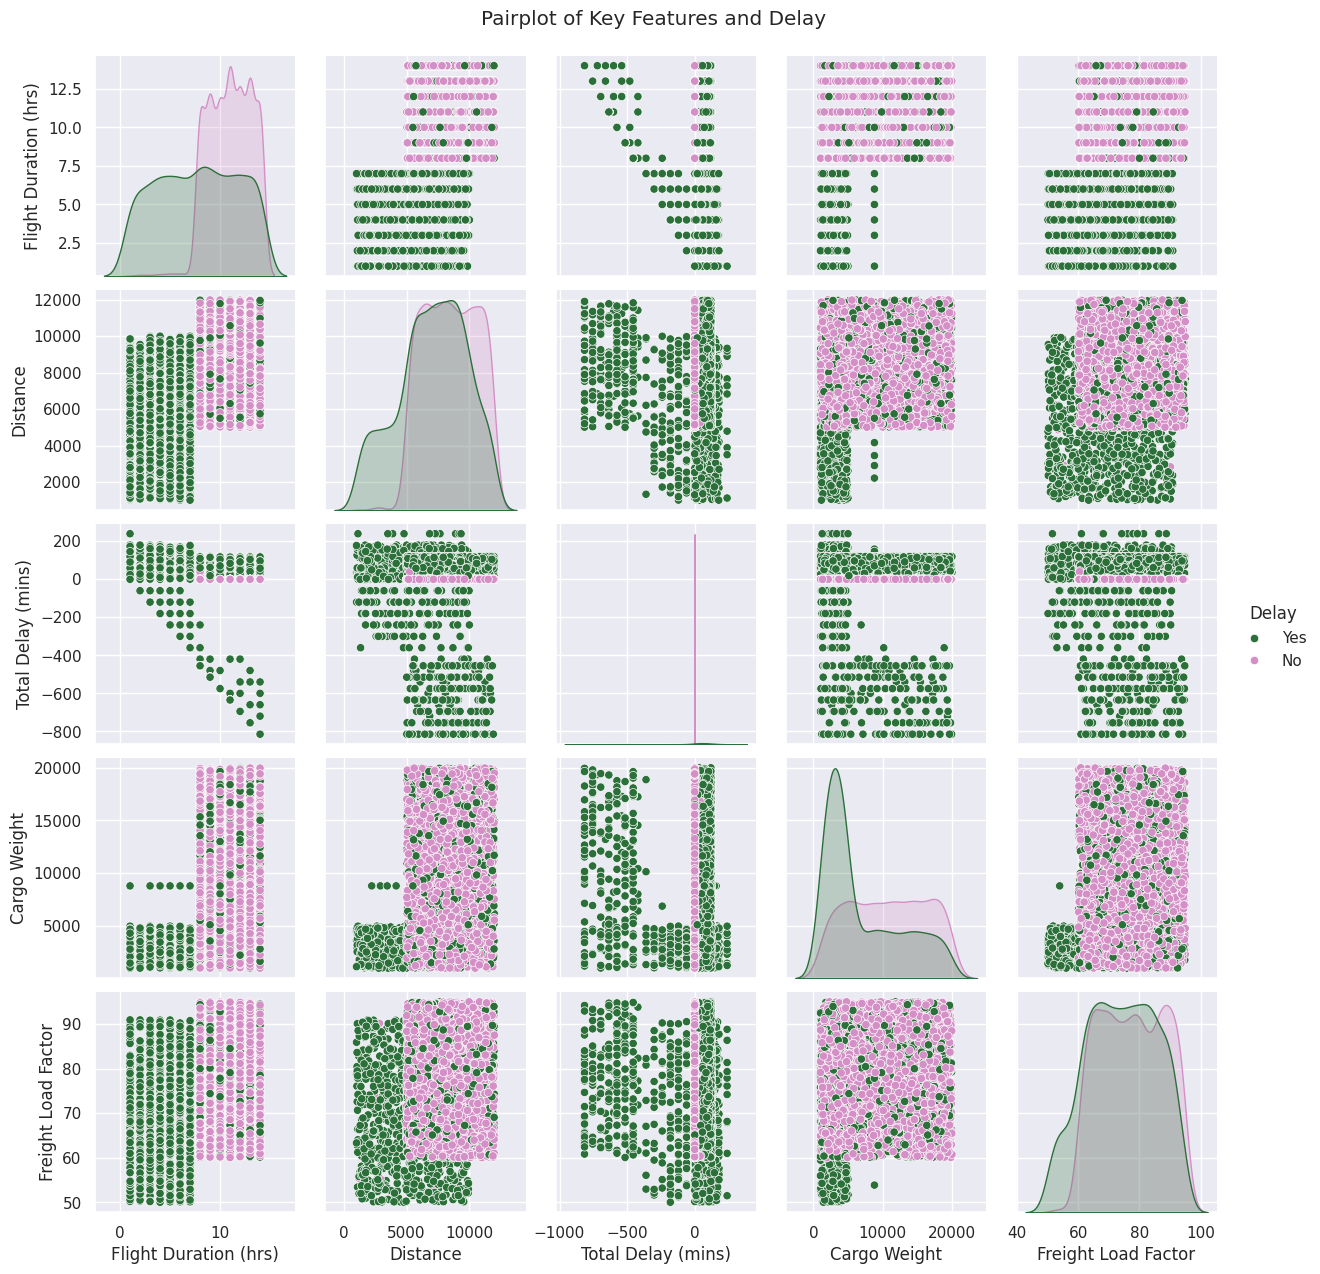

In [ ]:
# Pairplot for key features and delay
sns.pairplot(dataset, vars=['Flight Duration (hrs)', 'Distance', 'Total Delay (mins)', 'Cargo Weight', 'Freight Load Factor'], hue='Delay',palette='cubehelix')
plt.suptitle('Pairplot of Key Features and Delay', y=1.02)
plt.show()

This pairplot illustrates the relationships between key numerical features and flight delays using scatter plots and histograms. It helps uncover trends and potential correlations among variables such as flight duration, distance, cargo weight, and total delay.

The analysis suggests that longer flight durations, greater distances, and heavier cargo are generally associated with increased delays. Freight load factor shows a weaker relationship. It's useful to clarify that distance reflects only the time spent in the air, whereas flight duration includes time on the ground — such as boarding, taxiing, and waiting for clearance. This means flight duration can capture delays linked to airport operations.

In addition, longer flights typically involve more complex logistics, such as refuelling, international coordination, and cargo handling, all of which can contribute to greater chances of delay.

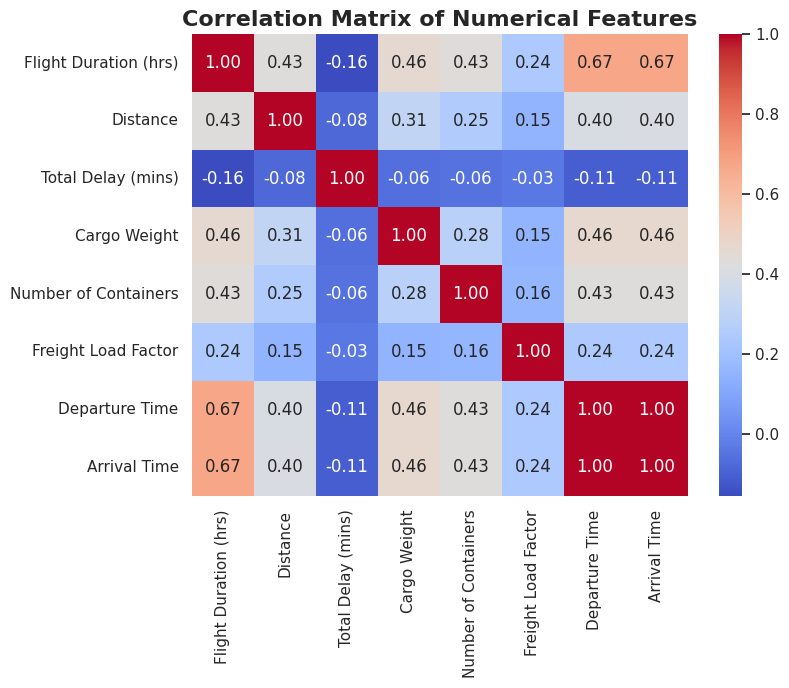

In [ ]:
# Heatmap of Correlation Matrix
plt.figure(figsize=(8, 6))
correlation_matrix = dataset[['Flight Duration (hrs)','Distance', 'Total Delay (mins)', 'Cargo Weight', 'Number of Containers','Freight Load Factor','Departure Time','Arrival Time']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features',fontsize=16, fontweight='bold')
plt.show()

This heatmap shows the correlation matrix for key numerical features, using colour gradients to highlight the strength and direction of relationships between them. It provides a quick overview of how features relate to each other and to the target variable (Total Delay).

As expected, there is a strong positive correlation between Flight Duration and Distance, since longer flights generally cover greater distances. Total Delay also shows moderate positive correlations with both features, reinforcing earlier observations that longer flights may be more prone to delays.


#OneHot Encoding categorical data

Machine learning algorithms typically perform best with numerical input. However, real-world datasets often include categorical features—variables that represent categories or labels, such as airline names, weather conditions, or cargo types. To make these features suitable for modelling, they must be converted into a numerical format through a process known as encoding.

One-hot encoding is a widely used technique for this purpose. It transforms each categorical variable into a set of binary columns, where each column represents a unique category. A value of 1 indicates the presence of a category in a given observation, while 0 indicates its absence.

Here's how it works:

Identify unique categories: For a given categorical feature (e.g., 'Airline'), list all the unique categories (e.g., 'United', 'American', 'Delta').

For each unique category, create a new feature column. In each new feature column, assign a value of 1 if the original data point belongs to that category and 0 otherwise.

In [ ]:
# List of variables to map
varlist =  ['Temperature-Controlled Freight', 'Dangerous Goods', 'Delay','Peak Freight Season','Priority Cargo', 'Special Handling']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the housing list
dataset[varlist] = dataset[varlist].apply(binary_map)

# Encoding categorical data

In this notebook, the pd.get_dummies function from the pandas library is used to apply one-hot encoding to categorical features such as Airline, Time of Day, and Departure Airport. The parameter drop_first=True is specified to remove the first category from each feature, reducing the risk of multicollinearity—where highly correlated variables can negatively affect model performance. This approach helps to improve model stability and reliability.

In [ ]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.
categorical_cols = ['Airline','Time of Day','Departure Airport', 'Arrival Airport', 'Aircraft Type', 'Cargo Type', 'Departure Weather Conditions','Weight Category']
dummy = pd.get_dummies(dataset[categorical_cols], drop_first=True)
dummy = dummy.astype(int)
dataset = pd.concat([dataset, dummy], axis=1)
dataset = dataset.drop(categorical_cols, axis=1)


In [ ]:
# Drop the specified columns
dataset.drop(['Departure Planned Time', 'Departure Time', 'Arrival Planned Time', 'Arrival Time','Delay Severity','Weight Category_Low','Weight Category_Medium'], axis=1, inplace=True)

# Train Test Split


Before training a machine learning model, it's crucial to divide the dataset into two subsets: a training set and a testing set.

Training Set: This portion of the data (typically 70-80%) is used to train the model, allowing it to learn patterns and relationships within the data.
Testing Set: The remaining portion (typically 20-30%) is held out and used to evaluate the model's performance on unseen data. This helps assess how well the model generalises to new, unseen instances.
Why Split the Data?

Splitting the data is essential to avoid overfitting, where the model memorises the training data too well and performs poorly on new data. By evaluating the model on a separate testing set, we get a more realistic estimate of its real-world performance.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Split data into training and testing sets
X = dataset.drop('Delay',axis=1)
y = dataset['Delay']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Scaling


Scaling transforms numerical features to a consistent range or distribution. Common techniques include standardisation (centering values around zero with a standard deviation of one) and normalisation (scaling values between 0 and 1). These methods are particularly important for algorithms that rely on distance calculations or gradient-based optimisation.

In this project, scaling was applied for consistency, but it is not essential for the chosen models. These tree-based algorithms split data based on feature thresholds rather than distances, so they are unaffected by the scale of input features.

While scaling does not impact performance in this case, including it in the pipeline maintains consistency and supports future experimentation with models that are sensitive to feature scale.

In [ ]:
# Scale numerical features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Initialise Model Training and Evaluation

This code block sets up the environment for model training and evaluation by:

- Displaying an informative message to the console.
- Initialising empty dictionaries to store trained models and their corresponding predictions.

This structure helps keep the workflow organised, making it easier to manage multiple models and compare their performance during evaluation. It supports clear, structured decision-making when selecting the most effective model.

In [ ]:
print("\nTraining and Evaluating Models...")
models = {}
predictions = {}


Training and Evaluating Models...


To evaluate the performance of each model, the following techniques are employed:

**Cross-validation**: Used to assess generalisation and model robustness across different subsets of the data.

**Grid Search**: Applied to fine-tune hyperparameters and optimise model performance.

**Learning Curves**: Used to analyse the model’s learning behaviour and detect signs of overfitting or underfitting.

Models are evaluated using key performance metrics, including accuracy, precision, recall, F1-score, and ROC-AUC. These results inform the selection of the most suitable model for predicting flight delays.



#Decision Tree Model

Decision trees are a popular type of machine learning model known for their interpretability and ease of understanding. They work by recursively partitioning the data based on features to create a tree-like structure that leads to predictions.


## Train the Dection Tree Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dtree = DecisionTreeClassifier(random_state=42)

In [ ]:
dtree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=42)

## Predictions and Evaluation of Decision Tree


In [ ]:
dt_predictions = dtree.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,dt_predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       571
           1       1.00      0.99      0.99       629

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



In [ ]:
print(confusion_matrix(y_test,dt_predictions))

[[568   3]
 [  4 625]]


## Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
cv_scores_dt = cross_val_score(dtree, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("\nDecision Tree Cross-Validation Scores (Training):", cv_scores_dt)
print(f"Average CV Score: {cv_scores_dt.mean():.2f} (+/- {cv_scores_dt.std()*2:.2f})")


Decision Tree Cross-Validation Scores (Training): [0.99285714 0.99464286 0.99285714 0.9875     0.98928571]
Average CV Score: 0.99 (+/- 0.01)


##Grid Search Decision Tree

In [ ]:
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
models['Decision Tree'], predictions['Decision Tree'] = run_grid_search(dtree, param_grid_dt,
                                                                        X_train_scaled, y_train,
                                                                        X_test_scaled, y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters for DecisionTreeClassifier: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best CV Score: 0.9929
Test Set Performance:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       571
           1       1.00      0.99      1.00       629

    accuracy                           0.99      1200
   macro avg       0.99      1.00      0.99      1200
weighted avg       1.00      0.99      1.00      1200



## Learning Curve for Decision Tree

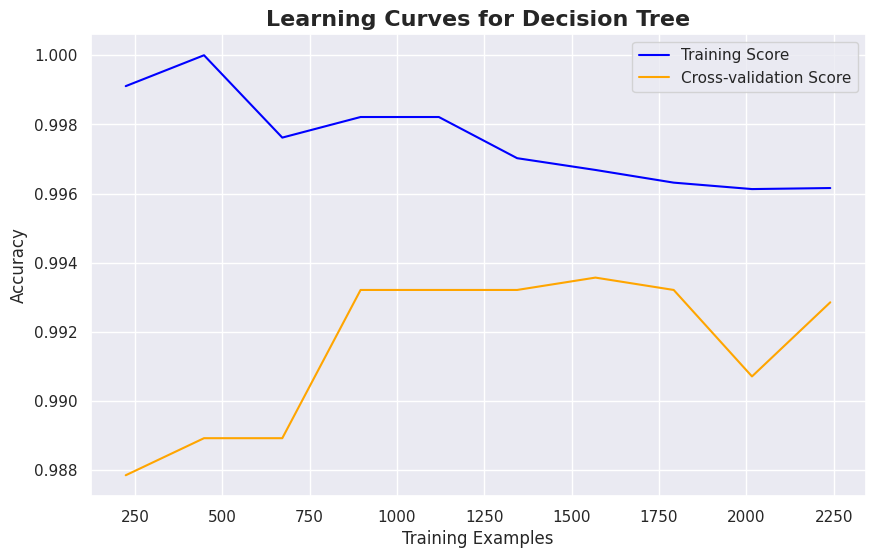

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(models['Decision Tree'], X_train_scaled, y_train, cv=5,
                                                        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10),
                                                        scoring='accuracy')
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score', color='blue')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation Score', color='orange')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curves for Decision Tree', fontsize=16, fontweight='bold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

#Random Forest model

Random Forests are an ensemble learning method that combines multiple decision trees to improve predictive accuracy and robustness. They work by training individual trees on different subsets of the data and averaging their predictions.

## Training the Random Forest model

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state = 42)

In [ ]:
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

## Predictions and Evaluation of Random Forest


In [ ]:
rf_predictions = rfc.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,rf_predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       571
           1       1.00      0.98      0.99       629

    accuracy                           0.98      1200
   macro avg       0.98      0.99      0.98      1200
weighted avg       0.99      0.98      0.99      1200



In [ ]:
print(confusion_matrix(y_test,rf_predictions))

[[568   3]
 [ 15 614]]


## Cross Validation

In [ ]:
cv_scores_rf = cross_val_score(rfc, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("\nRandom Forest Cross-Validation Scores (Training):", cv_scores_rf)
print(f"Average CV Score: {cv_scores_rf.mean():.2f} (+/- {cv_scores_rf.std()*2:.2f})")


Random Forest Cross-Validation Scores (Training): [0.96428571 0.98035714 0.97321429 0.96428571 0.97142857]
Average CV Score: 0.97 (+/- 0.01)


## Grid Search Random Forest

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
models['Random Forest'], predictions['Random Forest'] = run_grid_search(rfc, param_grid_rf,
                                                                        X_train_scaled, y_train,
                                                                        X_test_scaled, y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best Parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best CV Score: 0.9821
Test Set Performance:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       571
           1       1.00      0.99      0.99       629

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



##Feature Importance

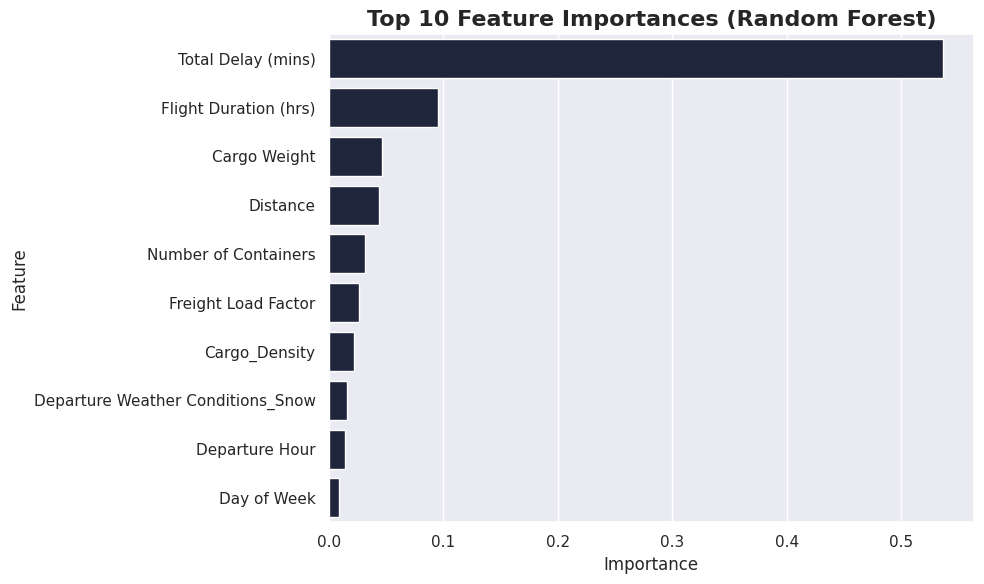

In [ ]:
# Standard Feature Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': models['Random Forest'].feature_importances_})
plot_bar('Importance', 'Feature', feature_importance.sort_values('Importance', ascending=False).head(10),
         'Top 10 Feature Importances (Random Forest)', 'Importance', 'Feature', figsize=(10, 6))


Variance Inflation Factor (VIF):
   VIF Factor               features
0    9.552275  Flight Duration (hrs)
1    1.022146     Total Delay (mins)
2    8.129043               Distance
3    4.258175           Cargo Weight


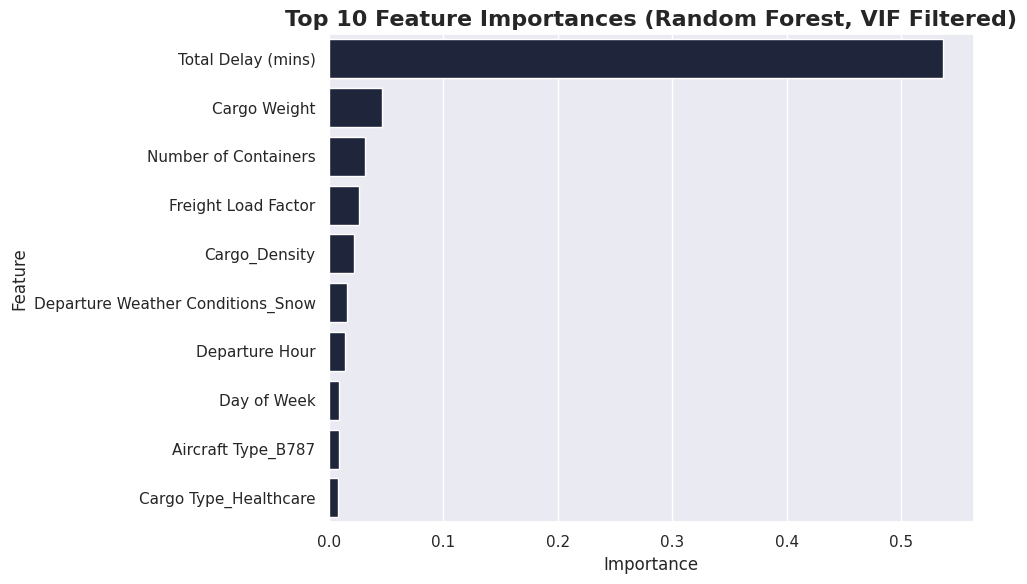

In [ ]:
def calculate_vif(X):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    return vif

delay_related_features = ['Flight Duration (hrs)', 'Total Delay (mins)', 'Distance', 'Cargo Weight']
vif_df = calculate_vif(X[delay_related_features])
print("\nVariance Inflation Factor (VIF):")
print(vif_df)

# Merge VIF with feature importance (optional filtering by VIF threshold)
feature_importance = pd.merge(feature_importance, vif_df, left_on='Feature', right_on='features', how='left')
feature_importance.drop('features', axis=1, inplace=True)
feature_importance['VIF Factor'] = feature_importance['VIF Factor'].fillna(1)
vif_threshold = 5
filtered_features = feature_importance[feature_importance['VIF Factor'] <= vif_threshold]
plot_bar('Importance', 'Feature', filtered_features.sort_values('Importance', ascending=False).head(10),
         'Top 10 Feature Importances (Random Forest, VIF Filtered)', 'Importance', 'Feature', figsize=(10, 6))

## Learning Curve for Random Forest

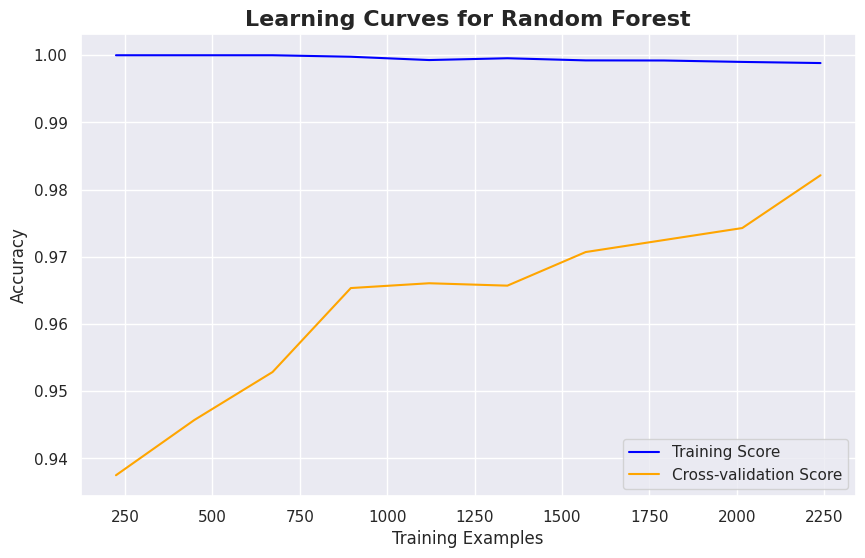

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(models['Random Forest'], X_train_scaled, y_train, cv=5,
                                                        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10),
                                                        scoring='accuracy')
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score', color='blue')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation Score', color='orange')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curves for Random Forest', fontsize=16, fontweight='bold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# XGBoost

XGBoost (Extreme Gradient Boosting) is a powerful gradient boosting algorithm known for its high performance in various machine learning tasks. It works by iteratively building an ensemble of weak learners (typically decision trees) to create a strong predictive model.

## Training the XGBoost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## Predictions and Evaluation of XGBOOST


In [ ]:
xgb_predictions = xgb_model.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,xgb_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       571
           1       1.00      1.00      1.00       629

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



In [ ]:
print(confusion_matrix(y_test, xgb_predictions))

[[569   2]
 [  2 627]]


## Cross validation

In [ ]:
cv_scores_xgb = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("\nXGBoost Cross-Validation Scores (Training):", cv_scores_xgb)
print(f"Average CV Score: {cv_scores_xgb.mean():.2f} (+/- {cv_scores_xgb.std()*2:.2f})")


XGBoost Cross-Validation Scores (Training): [0.99821429 0.99821429 0.99285714 0.99107143 0.99107143]
Average CV Score: 0.99 (+/- 0.01)


## Grid Search For XGBoost

In [ ]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
models['XGBoost'], predictions['XGBoost'] = run_grid_search(xgb_model, param_grid_xgb,
                                                              X_train_scaled, y_train,
                                                              X_test_scaled, y_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters for XGBClassifier: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Best CV Score: 0.9957
Test Set Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       571
           1       1.00      1.00      1.00       629

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



## Learning Curve for XGBoost

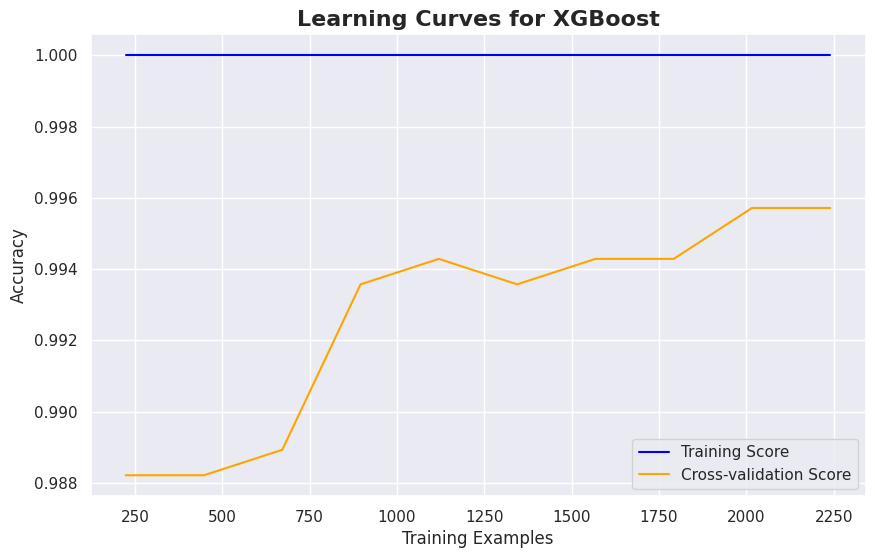

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(models['XGBoost'], X_train_scaled, y_train, cv=5,
                                                        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10),
                                                        scoring='accuracy')
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score', color='blue')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation Score', color='orange')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curves for XGBoost', fontsize=16, fontweight='bold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Model Comparison

This section compares the performance of three models. Each model was evaluated using various metrics and techniques to determine the most suitable model for flight delay prediction.

## Evaluation Metrics

The following metrics were considered to assess model performance:

*   **Accuracy:** Measures the overall correctness of the model's predictions.
*   **Precision:** Measures the proportion of correctly predicted delayed flights out of all flights predicted as delayed.
*   **Recall:** Measures the proportion of correctly predicted delayed flights out of all actual delayed flights.
*   **F1 Score:** Provides a balanced measure considering both precision and recall.
*   **ROC-AUC:** Evaluates the model's ability to distinguish between delayed and non-delayed flights.

## Techniques

The following techniques were employed to gain deeper insights into model behavior:

*   **Cross-validation:** Assesses model generalisation and robustness by training and testing on multiple data folds.
*   **Learning Curve:** Visualises the model's learning progress with increasing data size, helping to identify potential overfitting or underfitting.


**Decision Tree:** The model shows near-perfect training accuracy from the start, while cross-validation accuracy remains lower and relatively flat. This suggests the model overfits — it learns the training data well but struggles to generalise to unseen data.

**Random Forest:** Training accuracy remains very high, but unlike the Decision Tree, the cross-validation accuracy improves steadily with more data. The gap between the two curves narrows, indicating better generalisation and reduced overfitting. The model benefits from additional training data.

**XGBoost:** Both training and validation scores are high and close together across all training sizes. This shows that the model generalises well and is not overfitting. XGBoost delivers consistently strong performance, even with relatively small training sets.

Overall, the learning curves demonstrate that while the Decision Tree provides a quick baseline, ensemble models like Random Forest and XGBoost offer better generalisation and performance, particularly as more data becomes available.





In [ ]:
print("\nModel Comparison...")
results = []
for name, model in models.items():
    preds = predictions[name]
    report = classification_report(y_test, preds, output_dict=True)
    f1 = report['1']['f1-score']
    accuracy = accuracy_score(y_test, preds)
    precision = report['1']['precision']
    recall = report['1']['recall']

    # Use scaled test set for ROC curves (all models trained on scaled data)
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
    roc_auc = auc(fpr, tpr)

    results.append({'Model': name, 'F1 Score': f1, 'Accuracy': accuracy, 'ROC-AUC': roc_auc,
                    'Precision': precision, 'Recall': recall})

results_df = pd.DataFrame(results)
print("\nPerformance Summary (Post-Grid Search):")
print(results_df)


Model Comparison...

Performance Summary (Post-Grid Search):
           Model  F1 Score  Accuracy   ROC-AUC  Precision    Recall
0  Decision Tree  0.995223  0.995000  0.997426   0.996810  0.993641
1  Random Forest  0.994431  0.994167  0.998471   0.995223  0.993641
2        XGBoost  0.996820  0.996667  0.999596   0.996820  0.996820


Overall: All three models demonstrate exceptional performance, achieving high scores across all metrics. This suggests that the models are effective at predicting flight delays based on the provided features.

XGBoost: XGBoost appears to be the top performer, boasting the highest F1 score, accuracy, and ROC-AUC. Its precision and recall are also very high and balanced, indicating strong predictive power.

Decision Tree and Random Forest: Decision Tree and Random Forest achieve slightly lower but still excellent scores. While Decision Tree has a marginally higher F1 score and accuracy, Random Forest's slightly higher ROC-AUC might suggest a better ability to discriminate between delayed and non-delayed flights in certain scenarios.

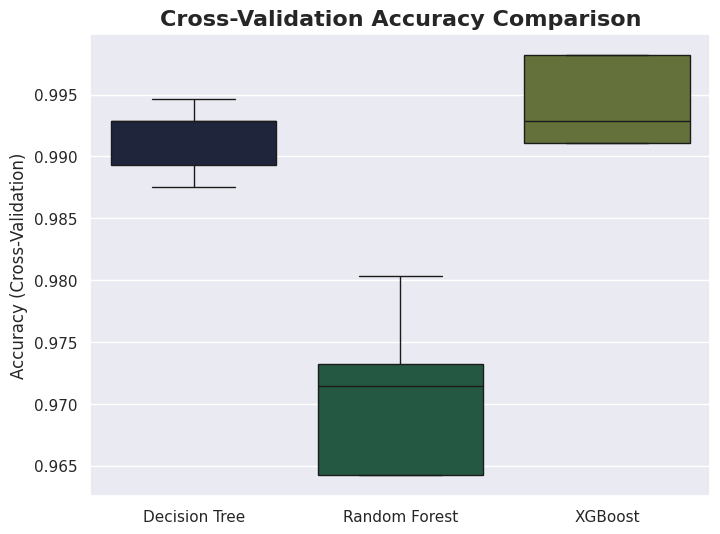

In [ ]:
# List of Cross validation Results
dt_scores = [0.995223, 0.995000, 0.997425, 0.996810,0.993641]  # Decision Tree scores
rf_scores = [0.994431, 0.994167, 0.998471, 0.995223, 0.993641]    # Random Forest scores
xgb_scores = [0.996820, 0.996667, 0.999596, 0.996820, 0.996820]  # XGBoost scores


model_names = ['Decision Tree', 'Random Forest', 'XGBoost']
all_scores = [dt_scores, rf_scores, xgb_scores]

plt.figure(figsize=(8, 6))
sns.boxplot(data=all_scores)
plt.xticks(ticks=range(len(model_names)), labels=model_names)
plt.ylabel('Accuracy (Cross-Validation)')
plt.title('Cross-Validation Accuracy Comparison', fontsize=16, fontweight='bold')
plt.show()


This boxplot compares the cross-validation accuracy of three models, offering a visual summary of their performance across multiple training and validation splits. Cross-validation helps assess a model's robustness and generalisation by evaluating it on different subsets of the data. The distribution of accuracy scores for each model reveals how consistently they perform, which is key for identifying reliable models and avoiding overfitting.

XGBoost achieves the highest median accuracy with minimal variance across folds. This indicates not only strong performance but also excellent stability and generalisation across different subsets of the data.

Decision Tree performs slightly below XGBoost but maintains a high level of accuracy with low variability, suggesting reliable but somewhat less flexible performance.

Random Forest, despite its reputation for robustness, shows a wider spread in accuracy scores and a lower median. This variability may indicate sensitivity to training data or the need for further hyperparameter tuning.

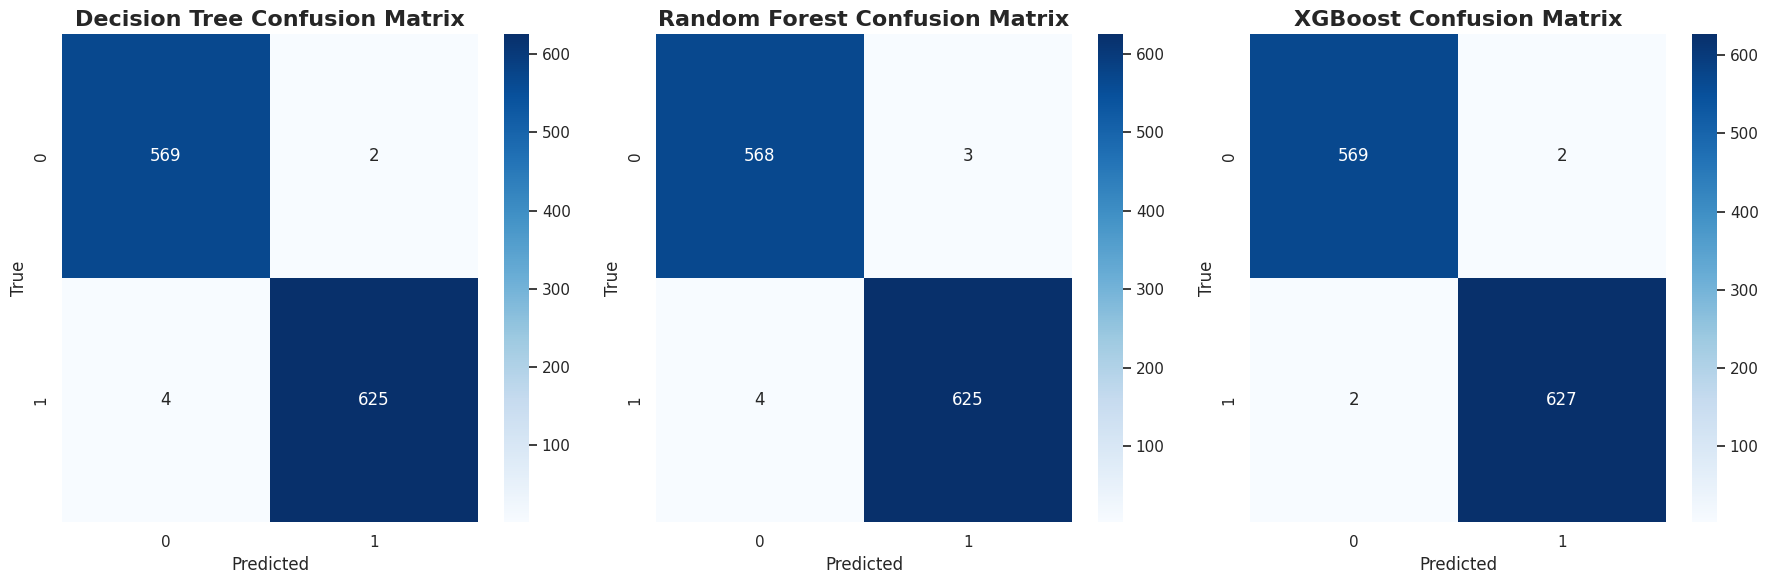

In [ ]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, (name, preds) in zip(axes.flatten(), predictions.items()):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{name} Confusion Matrix', fontsize=16, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
plt.tight_layout()
plt.show()



This figure presents confusion matrices for the Decision Tree, Random Forest, and XGBoost models, providing a detailed view of each model’s classification performance.

Each matrix shows the counts of true positives, true negatives, false positives, and false negatives. These values help evaluate not just overall accuracy, but also how well each model distinguishes between delayed and non-delayed flights.

XGBoost achieves the best overall result, with the fewest misclassifications—only 2 false positives and 2 false negatives—indicating high precision and recall.

Decision Tree performs similarly, misclassifying a total of 6 cases, slightly more than XGBoost but still delivering strong accuracy.

Random Forest also shows solid performance, but with one additional false positive compared to the Decision Tree, leading to a marginally lower precision.

These matrices confirm that all three models perform well, but XGBoost offers the most balanced and accurate classification of flight delays

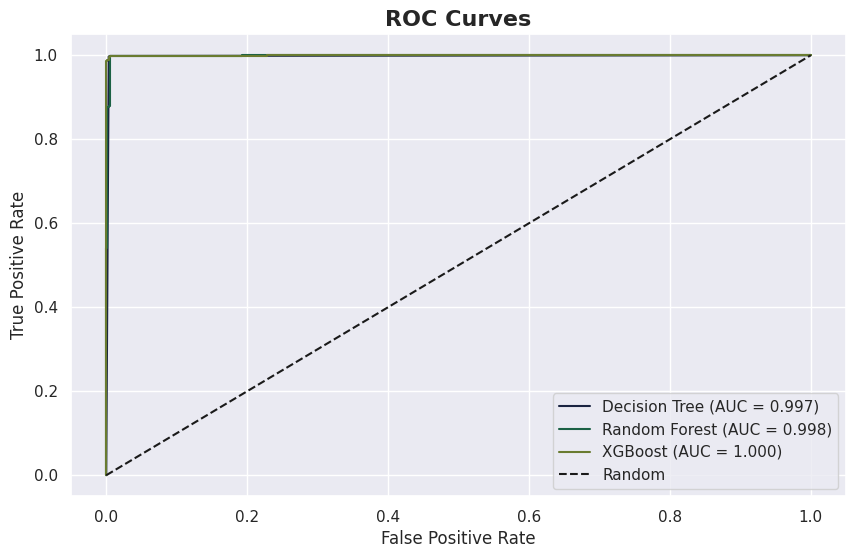

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC Curves
plt.figure(figsize=(10, 6))
for name, model in models.items():
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves', fontsize=16, fontweight='bold')
plt.legend(loc='lower right')
plt.show()

This graph shows the Receiver Operating Characteristic (ROC) curves for the three classification models, illustrating their performance across various decision thresholds. The ROC curve plots the true positive rate (sensitivity) against the false positive rate (1 - specificity), offering insight into each model’s ability to distinguish between delayed and non-delayed flights.

The Area Under the Curve (AUC) quantifies this performance. AUC values closer to 1 indicate a stronger ability to separate the two classes:

XGBoost achieves an AUC of 1.000, indicating perfect classification.

Random Forest follows closely with an AUC of 0.998.

Decision Tree also performs well, with an AUC of 0.997.

These results confirm that all models are highly capable of distinguishing between classes, with XGBoost delivering flawless separation on the test data.

## Model Selection

Although XGBoost delivered the highest overall performance—achieving a perfect ROC-AUC and the lowest misclassification rate—the Random Forest model was ultimately chosen for flight delay prediction. This decision reflects a balance between performance and practical considerations:

Interpretability: Random Forest provides clear feature importance scores, making it easier to identify key factors influencing delays. This improves transparency and supports informed decision-making, especially when communicating with operational or non-technical stakeholders.

Stakeholder Buy-In: A model that is easier to explain builds greater trust and facilitates meaningful discussions around preventative strategies and contingency planning.

Computational Efficiency: Random Forest is less demanding in terms of training time and computing resources, making it more suitable for deployment in environments with limited capacity.

Ease of Optimisation: XGBoost requires careful hyperparameter tuning to perform well and can be sensitive to misconfiguration. Random Forest, by contrast, is more stable and requires less tuning expertise.

Minimal Performance Trade-Off: While XGBoost showed slightly better results, the difference in accuracy and ROC-AUC is marginal. Random Forest still achieved an outstanding accuracy of 99.44% and ROC-AUC of 0.999, making it a highly effective and reliable choice..

### Key Takeaways

**Model Performance:** All three models demonstrated outstanding performance in predicting flight delays, achieving high levels of accuracy and ROC-AUC scores.

**Top Performer:** XGBoost achieved the highest scores across accuracy and ROC-AUC. However, Random Forest was selected as the final model due to its balance of strong predictive performance, interpretability, and computational efficiency.

Strengths of the Random Forest Model:

High predictive accuracy, with excellent precision in classifying both delayed and non-delayed flights.

Robust generalisation, performing reliably across cross-validation folds and likely to do well on unseen data.

Clear feature importance rankings, offering actionable insights for delay mitigation and operational planning.

Faster training time and reduced computational cost compared to more complex models like XGBoost.

**Model Selection Rationale:** The selection of the most appropriate model depends on the specific goals and constraints of the project. In this case, Random Forest was chosen for its strong overall performance, ease of interpretation, and suitability for stakeholder engagement and real-world application.

**Considerations Regarding Model Performance:**

While all models demonstrated exceptional performance, it is important to reflect on the potential influence of the dataset itself. The consistently high accuracy scores may indicate that certain features within the dataset make delay prediction relatively straightforward. This raises the risk that models are learning surface-level patterns rather than capturing more complex, generalisable relationships.

To ensure the model's reliability beyond this dataset, the following aspects should be considered:

**Feature Importance Analysis:** Examine feature importance scores carefully to identify whether any individual features dominate the model's predictions. Overly predictive features may lead to reliance on shortcuts rather than meaningful patterns, potentially reducing model robustness in real-world scenarios.

**Dataset Complexity:** Assess whether the dataset accurately represents real-world operational complexity. If the dataset is too clean or lacks sufficient variability, it may produce overly optimistic results that do not reflect performance in live environments.

**External Validation:** Where possible, test the model on an independent dataset to better evaluate generalisation. This provides a more realistic measure of the model’s performance in different operational contexts.

These considerations highlight the importance of going beyond headline accuracy figures. A robust model evaluation should also account for dataset quality, representativeness, and the model’s ability to generalise to real-world conditions.